# Model Training and Storing

In [48]:
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pickle
import joblib

In [49]:
# Load data from JSON-line files
train_records = pd.read_json("./data/train.json",orient="records", lines=True)
test_records = pd.read_json("./data/test.json",orient="records", lines=True)

In [50]:
# flatten the images (Pixel values)
X_test = test_records.array
X_train = train_records.array
data_test = np.array(X_test.to_list()).reshape(10000,-1)
data_train = np.array(X_train.to_list()).reshape(60000,-1)

In [51]:
# Labels
y_test=test_records.label
y_train=train_records.label

In [52]:
# Create an SVM classifier
clf = svm.SVC(
    gamma=0.001, 
    probability=True
)

# Fit the model on training data
clf.fit(data_train, y_train)

# Predict (digit) on test data
predicted = clf.predict(data_test)

In [53]:
# Print a classification report
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(gamma=0.001, probability=True):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.93      0.94      0.93      1010
           4       0.92      0.95      0.94       982
           5       0.92      0.91      0.92       892
           6       0.95      0.96      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.91      0.92       974
           9       0.94      0.91      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000




Confusion matrix:
[[ 967    0    2    0    0    5    4    1    1    0]
 [   0 1119    2    3    0    1    3    1    6    0]
 [  10    1  953    9   11    1   13   11   21    2]
 [   1    1   15  948    1   17    1   10   12    4]
 [   1    2    7    0  935    0    7    2    2   26]
 [   7    5    5   32    8  808   11    2    9    5]
 [   9    3    4    1    6   11  923    0    1    0]
 [   2   13   22    5    8    1    0  953    4   20]
 [   4    7    7   14    8   24   10    7  890    3]
 [   8    6    0   12   34    6    1   15    6  921]]


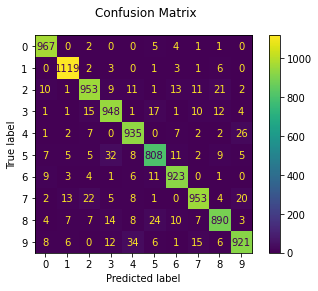

In [54]:
# Plot a confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [56]:
# Store saved model
with open("./binaries/uncompressed_sklearn_mnist.pkl", "wb") as f:
    pickle.dump(clf, f)

In [55]:
# Compress and Store saved model
import joblib
joblib.dump(clf, "./binaries/sklearn_mnist.pkl", compress=3)

['./binaries/sklearn_mnist.pkl']

In [58]:
# To test that the saved model can be loaded and used for predictions, we proceed as follows:
model_from_saved_model = joblib.load(open("./binaries/sklearn_mnist.pkl", "rb"))
print("Sample prediction : ", model_from_saved_model.predict(data_test[:1]))
print("Sample probability: ", model_from_saved_model.predict_proba(data_test[:1]))

Sample prediction :  [7]
Sample probability:  [[2.63275252e-04 2.70762117e-06 3.97105281e-04 3.49581103e-03
  3.60987905e-05 5.99369886e-05 7.53118906e-07 9.94802720e-01
  3.45988000e-05 9.06993534e-04]]


# Input/Output Schema

In [59]:
# input_schema.avsc

input_schema = {
    "name": "input_schema",
    "type": "record",
    "fields": [
        {
            "name": "id",
            "type": "int"
        },
        {
            "name": "array",
            "type": {
                "type": "array",
                "items": {
                    "type": "array",
                    "items": "float"
                }
            }
        },
        {
            "name": "label",
            "type": "int"
        }
    ]
}


output_schema = {
    "name": "output_schema",
    "type": "record",
    "fields": [
        {
            "name": "id",
            "type": "int"
        },
        {
            "name": "label",
            "type": "int"
        },
        {
            "name": "predicted_probs",
            "type": {
                "type": "array",
                "items": "float"
            }
        },
        {
            "name": "score",
            "type": "int"
        }
    ]
}

with open("input_schema.avsc", "w") as f:
    json.dump(input_schema, f)
f.close()

with open("output_schema.avsc", "w") as f:
    json.dump(output_schema, f)
f.close()

# Model Script

In [60]:
# modelop.schema.0: input_schema.avsc
# modelop.schema.1: output_schema.avsc

import joblib
import numpy as np


# modelop.init
def begin():
    global model
    # Loading model from trained artifact    
    model = joblib.load(open("./binaries/sklearn_mnist.pkl","rb"))


# modelop.score
def action(datum):
    
    # Compute 10 probabilities, 1 for each possible digit
    predicted_probs = model.predict_proba(np.array(datum['array']).ravel().reshape(1,-1)).tolist()[0]
    
    # Add these probabilities to the output
    datum["predicted_probs"] = predicted_probs

    # Add the best possible matching digit to the output
    datum["score"] = np.argmax(predicted_probs)

    # Remove input array from output
    del datum["array"]
    
    yield datum

In [61]:
# Let's test the model by running the begin() function to load the saved model first, then calling
# the action function on a sample input image
begin()

sample_score = next(
    action(
        {
            "id":0,
            "array":[
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.0117647059,0.0705882353,0.0705882353,0.0705882353,0.4941176471,0.5333333333,0.6862745098,0.1019607843,0.6509803922,1.0,0.968627451,0.4980392157,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.1176470588,0.1411764706,0.368627451,0.6039215686,0.6666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.8823529412,0.6745098039,0.9921568627,0.9490196078,0.7647058824,0.2509803922,0,0,0,0],
                [0,0,0,0,0,0,0,0.1921568627,0.9333333333,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9843137255,0.3647058824,0.3215686275,0.3215686275,0.2196078431,0.1529411765,0,0,0,0,0],
                [0,0,0,0,0,0,0,0.0705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.7137254902,0.968627451,0.9450980392,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.3137254902,0.6117647059,0.4196078431,0.9921568627,0.9921568627,0.8039215686,0.0431372549,0,0.168627451,0.6039215686,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0.0549019608,0.0039215686,0.6039215686,0.9921568627,0.3529411765,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0.5450980392,0.9921568627,0.7450980392,0.0078431373,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0.0431372549,0.7450980392,0.9921568627,0.2745098039,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.137254902,0.9450980392,0.8823529412,0.6274509804,0.4235294118,0.0039215686,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0.3176470588,0.9411764706,0.9921568627,0.9921568627,0.4666666667,0.0980392157,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1764705882,0.7294117647,0.9921568627,0.9921568627,0.5882352941,0.1058823529,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.062745098,0.3647058824,0.9882352941,0.9921568627,0.7333333333,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9764705882,0.9921568627,0.9764705882,0.2509803922,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1803921569,0.5098039216,0.7176470588,0.9921568627,0.9921568627,0.8117647059,0.0078431373,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.1529411765,0.5803921569,0.8980392157,0.9921568627,0.9921568627,0.9921568627,0.9803921569,0.7137254902,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0.0941176471,0.4470588235,0.8666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7882352941,0.3058823529,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.0901960784,0.2588235294,0.8352941176,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.3176470588,0.0078431373,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0.0705882353,0.6705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7647058824,0.3137254902,0.0352941176,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0.2156862745,0.6745098039,0.8862745098,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9568627451,0.5215686275,0.0431372549,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0.5333333333,0.9921568627,0.9921568627,0.9921568627,0.831372549,0.5294117647,0.5176470588,0.062745098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ],
            "label":5
        }
    )
)

In [62]:
# Here's the output dictionary
sample_score

{'id': 0,
 'label': 5,
 'predictes_probs': [0.001067094500798651,
  0.000889057811453956,
  0.011885932944350731,
  0.12392592586563242,
  8.91437288146051e-05,
  0.8560558169237682,
  0.0003376030798716899,
  0.001987141397948426,
  0.002563834081063412,
  0.0011984496662976257],
 'score': 5}